[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ourownstory/neural_prophet/blob/master/tutorials/feature-use/benchmarking.ipynb)

# Running benchmarking experiments
Note: The Benchmarking Framework does currently not properly support auto-regression or lagged covariates with multiple step ahead forecasts.

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes
    
import pandas as pd
from neuralprophet import NeuralProphet, set_log_level
from neuralprophet.benchmark import Dataset, NeuralProphetModel, ProphetModel
from neuralprophet.benchmark import SimpleBenchmark, CrossValidationBenchmark
set_log_level("ERROR")

WARNING - (NP.benchmark.<module>) - Benchmarking Framework is not covered by tests. Please report any bugs you find.


## Load data

In [2]:
data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"

air_passengers_df = pd.read_csv(data_location + 'air_passengers.csv')
peyton_manning_df = pd.read_csv(data_location + 'wp_log_peyton_manning.csv')
# retail_sales_df = pd.read_csv(data_location + 'retail_sales.csv')
# yosemite_temps_df = pd.read_csv(data_location +  'yosemite_temps.csv')
# ercot_load_df = pd.read_csv(data_location +  'ERCOT_load_2004_2021Sept.csv')[['ds', 'y']]

## 0. Configure Datasets and Model Parameters
First, we define the datasets that we would like to benchmerk on.
Next, we define the models that we want to evaluate and set their hyperparameters.

In [3]:
dataset_list = [
    Dataset(df = air_passengers_df, name = "air_passengers", freq = "MS"),
    # Dataset(df = peyton_manning_df, name = "peyton_manning", freq = "D"),
    # Dataset(df = retail_sales_df, name = "retail_sales", freq = "D"),
    # Dataset(df = yosemite_temps_df, name = "yosemite_temps", freq = "5min"),
    # Dataset(df = ercot_load_df, name = "ercot_load", freq = "H"),
]
model_classes_and_params = [
    (NeuralProphetModel, {"seasonality_mode": "multiplicative", "learning_rate": 0.1}),
    (ProphetModel, {"seasonality_mode": "multiplicative"})
]

Note: As all the classes used in the Benchmark framework are dataclasses, 
they have a print function, allowing us to peek into them if we like:

In [4]:
model_classes_and_params

[(neuralprophet.benchmark.NeuralProphetModel,
  {'seasonality_mode': 'multiplicative', 'learning_rate': 0.1}),
 (neuralprophet.benchmark.ProphetModel,
  {'seasonality_mode': 'multiplicative'})]

## 1. SimpleBenchmark
Setting up a series of Train Test Experiments is quick:

In [5]:
benchmark = SimpleBenchmark(
    model_classes_and_params=model_classes_and_params, # iterate over this list of tuples
    datasets=dataset_list, # iterate over this list
    metrics=["MAE", "MSE", "MASE", "RMSE"],
    test_percentage=25,
)
results_train, results_test = benchmark.run()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.                                                   
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.35721
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       383.095   0.000197806       75.6156     0.07304           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       383.482   0.000187545       141.645   1.283e-06       0.001      179  LS failed, Hessian reset 
     159       384.105   0.000328631       165.657   3.031e-06       0.001      277  LS failed, Hessian reset 
     199       384.233   0.000179066       78.5608      0.4924      0.4924      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       385.249    0.00016096       76.7537      0.2907      0.2907      446   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     314       385.282   9.21668e-05       100.953   1.111e-06       0.001      501  LS failed, Hessian rese

In [6]:
results_test

,data,model,params,MAE,MSE,MASE,RMSE
0,air_passengers,NeuralProphet,"{'seasonality_mode': 'multiplicative', 'learni...",24.735352,840.142709,0.569564,28.985215
1,air_passengers,Prophet,{'seasonality_mode': 'multiplicative'},29.818648,1142.139138,0.686614,33.795549


## 2. CrossValidationBenchmark
Setting up a series of crossvalidated experiments is just as simple:

In [7]:
benchmark_cv = CrossValidationBenchmark(
    model_classes_and_params=model_classes_and_params, # iterate over this list of tuples
    datasets=dataset_list, # iterate over this list
    metrics=["MASE", "RMSE"],
    test_percentage=10,
    num_folds=3,
    fold_overlap_pct=0,
)
results_summary, results_train, results_test = benchmark_cv.run()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.                                                   
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.98895
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       350.915    0.00325811       196.694           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       351.155   0.000233968       134.526   1.399e-06       0.001      162  LS failed, Hessian reset 
     199       353.131    0.00201438       70.7522           1           1      283   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       353.377   5.99429e-05       69.2164   7.826e-07       0.001      370  LS failed, Hessian reset 
     281       353.384   5.18279e-09       56.5325      0.1585      0.1585      424   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.51834
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       393.504    0.00277682       276.611           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       395.162   1.61667e-05       79.7081      0.2124           1      267   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       395.946   2.07027e-06       61.0733      0.3241      0.9158      388   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     332       395.947    9.4293e-06       89.0558   1.456e-07       0.001      469  LS failed, Hessian reset 
     390       395.971   0.000115224       75.2948   1.388e-06       0.001      582  LS failed, Hessian reset 
     399        395.98   2.13971e-05       62.0906      0.1864      0.6044      594   
    Iter      log pro

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.39409
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       448.575    0.00291197       113.356           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       449.307   0.000266638       81.6888   4.045e-06       0.001      242  LS failed, Hessian reset 
     193       449.369    6.2105e-05       74.4287   8.427e-07       0.001      316  LS failed, Hessian reset 
     199       449.371    5.6194e-06       63.5301       1.144      0.1144      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     236       449.371   4.61448e-09       82.9525     0.02399     0.02399      380   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


We now also get a summary DataFrame showing the metrics' mean and standard deviation over all folds.

In [8]:
results_summary

,data,model,params,MASE,RMSE,MASE_std,RMSE_std,split
0,air_passengers,NeuralProphet,"{'seasonality_mode': 'multiplicative', 'learni...",0.280561,7.747557,0.008491,0.573085,train
1,air_passengers,Prophet,{'seasonality_mode': 'multiplicative'},0.310869,8.616463,0.021078,1.266764,train
0,air_passengers,NeuralProphet,"{'seasonality_mode': 'multiplicative', 'learni...",0.487238,22.624238,0.142295,5.797322,test
1,air_passengers,Prophet,{'seasonality_mode': 'multiplicative'},0.479454,22.778341,0.109195,4.224042,test


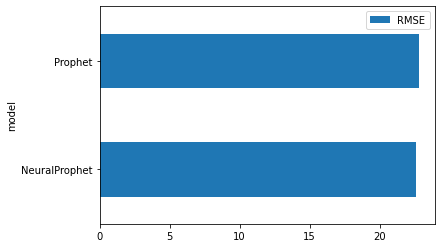

In [9]:
air_passengers = results_summary[results_summary['data'] == 'air_passengers']
air_passengers = air_passengers[air_passengers['split'] == 'test']
plt = air_passengers.plot(x='model', y='RMSE', kind='barh')

The metrics for each fold are also recoreded individually:

In [10]:
results_test

,data,model,params,MASE,RMSE
0,air_passengers,NeuralProphet,"{'seasonality_mode': 'multiplicative', 'learni...","[0.5137980049750044, 0.3012079224479569, 0.646...","[21.54880101535717, 16.12306629964537, 30.2008..."
1,air_passengers,Prophet,{'seasonality_mode': 'multiplicative'},"[0.5885898654326461, 0.3302688815416577, 0.519...","[24.617703272976527, 16.936631879241148, 26.78..."


## 3. Manual Benchmark
If you need more control over the individual Experiments, you can set them up manually:

In [12]:
from neuralprophet.benchmark import SimpleExperiment, CrossValidationExperiment
from neuralprophet.benchmark import ManualBenchmark, ManualCVBenchmark

### 3.1 ManualBenchmark: Manual SimpleExperiment Benchmark

In [ ]:
air_passengers_df = pd.read_csv(data_location + 'air_passengers.csv')
peyton_manning_df = pd.read_csv(data_location + 'wp_log_peyton_manning.csv')
metrics = ["MAE", "MSE", "RMSE", "MASE", "MSSE", "MAPE", "SMAPE"]
experiments = [
    SimpleExperiment(
        model_class=NeuralProphetModel,
        params={"seasonality_mode": "multiplicative", "learning_rate": 0.1},
        data=Dataset(df=air_passengers_df, name="air_passengers", freq="MS"),
        metrics=metrics,
        test_percentage=25,
    ),
    SimpleExperiment(
        model_class=ProphetModel,
        params={"seasonality_mode": "multiplicative", },
        data=Dataset(df=air_passengers_df, name="air_passengers", freq="MS"),
        metrics=metrics,
        test_percentage=25,
    ),
    SimpleExperiment(
        model_class=NeuralProphetModel,
        params={"learning_rate": 0.1},
        data=Dataset(df=peyton_manning_df, name="peyton_manning", freq="D"),
        metrics=metrics,
        test_percentage=15,
    ),
    SimpleExperiment(
        model_class=ProphetModel,
        params={},
        data=Dataset(df=peyton_manning_df, name="peyton_manning", freq="D"),
        metrics=metrics,
        test_percentage=15,
    ),
]
benchmark = ManualBenchmark(
    experiments=experiments,
    metrics=metrics,
)
results_train, results_test = benchmark.run()

In [14]:
results_test

,data,model,params,MAE,MSE,RMSE,MASE,MSSE,MAPE,SMAPE
0,air_passengers,NeuralProphet,"{'seasonality_mode': 'multiplicative', 'learni...",24.309260,814.949157,28.547314,0.559753,0.313215,5.832401,2.805304
1,air_passengers,Prophet,{'seasonality_mode': 'multiplicative'},29.818648,1142.139138,33.795549,0.686614,0.438966,7.471930,3.558548
2,peyton_manning,NeuralProphet,{'learning_rate': 0.1},0.547958,0.413614,0.643128,1.552570,1.553492,7.049260,3.394707
3,peyton_manning,Prophet,{},0.594528,0.463643,0.680913,1.684520,1.741397,7.673804,3.682554


### 3.2 ManualCVBenchmark: Manual CrossValidationExperiment Benchmark

In [ ]:
air_passengers_df = pd.read_csv(data_location + 'air_passengers.csv')
experiments = [
    CrossValidationExperiment(
        model_class=NeuralProphetModel,
        params={"seasonality_mode": "multiplicative", "learning_rate": 0.1},
        data=Dataset(df=air_passengers_df, name="air_passengers", freq="MS"),
        metrics=metrics,
        test_percentage=10,
        num_folds=3,
        fold_overlap_pct=0,
    ),
    CrossValidationExperiment(
        model_class=ProphetModel,
        params={"seasonality_mode": "multiplicative", },
        data=Dataset(df=air_passengers_df, name="air_passengers", freq="MS"),
        metrics=metrics,
        test_percentage=10,
        num_folds=3,
        fold_overlap_pct=0,
    ),
]
benchmark_cv = ManualCVBenchmark(
    experiments=experiments,
    metrics=metrics,
)
results_summary, results_train, results_test = benchmark_cv.run()

In [16]:
results_summary

,data,model,params,MAE,MSE,RMSE,MASE,MSSE,MAPE,SMAPE,MAE_std,MSE_std,RMSE_std,MASE_std,MSSE_std,MAPE_std,SMAPE_std,split
0,air_passengers,NeuralProphet,"{'seasonality_mode': 'multiplicative', 'learni...",5.918674,59.100526,7.651468,0.277568,0.078296,2.995700,1.486260,0.578625,11.085565,0.745361,0.009963,0.007303,0.059359,0.030063,train
1,air_passengers,Prophet,{'seasonality_mode': 'multiplicative'},6.655735,75.848123,8.616463,0.310869,0.098696,3.089578,1.553327,0.952939,20.968356,1.266764,0.021078,0.014689,0.261419,0.132790,train
0,air_passengers,NeuralProphet,"{'seasonality_mode': 'multiplicative', 'learni...",19.341793,523.294861,22.197297,0.477588,0.230734,4.584047,2.316405,6.797038,255.169097,5.529454,0.138682,0.090388,1.432749,0.757329,test
1,air_passengers,Prophet,{'seasonality_mode': 'multiplicative'},19.052098,536.695336,22.778341,0.479454,0.249282,4.604149,2.272174,3.876074,182.404522,4.224042,0.109195,0.103208,0.710556,0.353903,test
